# Neural ODE

System identification on a possibly sparse dataset of autonomous ODEs

In [144]:
import time
from tqdm import tqdm
import diffrax
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from interpolation import ZOHInterpolation as Interpolation
#from diffrax import LinearInterpolation as Interpolation
from diffrax import LinearInterpolation

In [145]:
%matplotlib widget

In [146]:
seed = 1234
key = jr.PRNGKey(seed)

In [147]:
@jax.jit
def generate_batch(key):
    # data
    nx = 2 # number of states
    nu = 1
    batch_size = 64 # number of sequences in the dataset
    seq_len = 1_000 # length of each sequence (number of time steps)
    x0key, ukey, pkey = jr.split(key, 3) # initial state, input, system
    t0 = 0
    t1 = 10
    ts = jnp.linspace(t0, t1, seq_len)
    dt0 = ts[1] - ts[0]

    batch_x0 = jr.uniform(x0key, (batch_size, nx), minval=-1, maxval=1)
    batch_u = jr.uniform(ukey, (batch_size, seq_len, nu), minval=-1, maxval=1)
    params_nominal = jnp.array([1, 0.1]) 
    params = params_nominal * jr.uniform(pkey, (batch_size, 2), minval=0.9, maxval=1.1) # each parameter +/- 10%

    def f_xu(x, u, args):
        """ Toy system: point mass with friction and force"""
        p, v = x # position, velocity
        F, = u # or F = u[0]    
        M, b = args
        dp = v
        dv = -b/M * v + 1/M * F
        dx = jnp.array([dp, dv])
        return dx

    def solve(ts, x0, u, params):
        u_fun = Interpolation(ts=ts, ys=u)
        def vector_field(t, y, args):
            x = y # state rename...
            ut = u_fun.evaluate(t)
            dx = f_xu(x, ut, args)
            return dx
        
        sol = diffrax.diffeqsolve(
            terms=diffrax.ODETerm(vector_field),
            solver=diffrax.Dopri5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=dt0,
            y0=x0,
            saveat=diffrax.SaveAt(ts=ts),
            args=params,
            max_steps=seq_len
        )
        return sol.ys
    
    batch_x = jax.vmap(solve, in_axes=(None, 0, 0, 0))(ts, batch_x0, batch_u, params)
    return batch_x, batch_u, params 

def generate_batches(key):
    while(True):
        key, subkey = jr.split(key, 2)
        yield generate_batch(subkey)

In [148]:
train_dl = generate_batches(key)
for idx, (batch_x, batch_u, batch_params) in tqdm(enumerate(train_dl)):
    if idx == 100:
        break

batch_u.shape

100it [00:01, 93.54it/s]


(64, 1000, 1)

In [152]:
idx = 10
x = batch_x[idx]
u = batch_u[idx]
x0 = x[0]
params = batch_params[idx]

In [153]:
import scipy

seq_len = 1_000 # length of each sequence (number of time steps)
t0 = 0
t1 = 10
ts = jnp.linspace(t0, t1, seq_len)
dt0 = ts[1] - ts[0]

def f_xu(x, u, args):
    """ Toy system: point mass with friction and force"""
    p, v = x # position, velocity
    F, = u # or F = u[0]    
    M, b = args
    dp = v
    dv = -b/M * v + 1/M * F
    dx = jnp.array([dp, dv])
    return dx

u_fun = Interpolation(ts=ts, ys=u)

def fun(t, y, args):
    x = y # state rename...
    ut = u_fun.evaluate(t)
    dx = f_xu(x, ut, args)
    return dx
        
out = scipy.integrate.solve_ivp(fun, t_span=(ts[0], ts[-1]), y0=x0, method='RK45', t_eval=ts, dense_output=False, args=(params,), max_step=dt0, first_step=dt0, min_step=dt0)#, min_step=dt0)
x_scipy = out.y.T

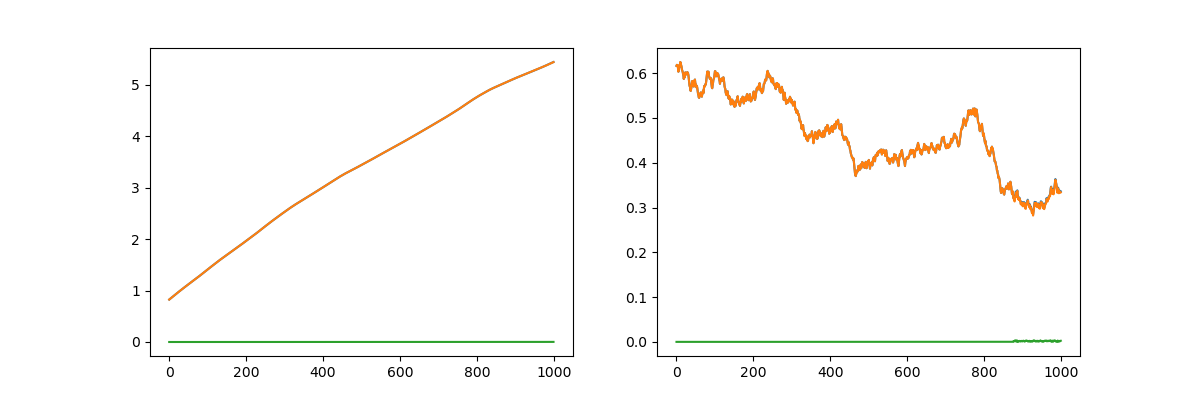

In [154]:
fix, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(x[:, 0])
ax[0].plot(x_scipy[:, 0])
ax[0].plot(x[:, 0] - x_scipy[:, 0])
ax[1].plot(x[:, 1])
ax[1].plot(x_scipy[:, 1])
ax[1].plot(x[:, 1] - x_scipy[:, 1])